# Playing with VQE

Try to optimize an anisotropic exchange Hamiltonian (z_1 x z_2

## Content
1. Calculating hamiltonian estimate using self-made code
2. Calculate the estimate using Estimator with real QC
3. Calculate the estimate using StateVectorEstimate modules (QC simulations)
4. Optimization of the state using COBYLA optimizer

In [2]:
#Qiskit modules
import qiskit
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.primitives import StatevectorSampler, StatevectorEstimator




#math modules
import math
# SciPy minimizer routine
from scipy.optimize import minimize

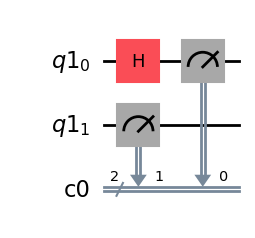

In [3]:
bit_size = 2

q_r = Q_R(bit_size)
cl_r = C_R(bit_size)
qc = QuantumCircuit(q_r, cl_r)

qc.h(0)

for i in range(bit_size):
    qc.measure(i, i)

qc.draw('mpl')

In [22]:
shot_num = 4096
simulator = AerSimulator()
qc_tr = transpile(qc, simulator)
result = simulator.run(qc_tr,shots = shot_num).result()
counts = result.get_counts(qc_tr)



## Calculating observable Z1 x Z2

In [23]:
zz = 0
for dic in counts:
    if dic == '00':
        zz = zz + counts[dic]
    if dic == '01':
        zz = zz - counts[dic]
    if dic == '10':
        zz = zz - counts[dic]
    if dic == '11':
        zz = zz + counts[dic]
zz = zz / shot_num
print(zz)

-0.0400390625


## Calculating observable Z1 x Z2 using Qiskit estimator and real QC

In [4]:
# Made a Hamiltonian for masurement
from qiskit.quantum_info import SparsePauliOp
interactions = [("ZZ", [0, 1], 1)]
hamiltonian = SparsePauliOp.from_sparse_list(interactions, num_qubits=bit_size)
print(hamiltonian)

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])


In [32]:
# Choose real QC to run the cicruit
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

ibm_brisbane


In [38]:
# transpile the circuit to chosen QC ISA
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc)
isa_observable = hamiltonian.apply_layout(isa_circuit.layout)

#Run the circuit and get the measured Hamiltonian estimate
estimator = Estimator(mode=backend)
pub = (isa_circuit, [isa_observable])
result = estimator.run(pubs=[pub]).result()
energy = result[0].data.evs[0]

In [39]:
energy

-0.001388888888888889

## Calculating obsrvables using ideal qiskit simulations - StateVectorEstimator package

Here the quantum circuit SHOULD NOT have any measurement gates.
The estimator is ideal and has no noise.

In [18]:
bit_size = 2

q_r = Q_R(bit_size)
cl_r = C_R(bit_size)
qc = QuantumCircuit(q_r, cl_r)

qc.x(0)
qc.x(1)


estimator = StatevectorEstimator()
job = estimator.run([(qc, hamiltonian)])
estimator_expvals = job.result()[0].data.evs
estimator_expvals

array(1.)

In [28]:
#from qiskit.circuit.library import RYGate
def vqc(theta, bit_size):
    qr = Q_R(bit_size)
    v_qc = QuantumCircuit(qr)
    for i in range(bit_size):
        v_qc.ry(theta[i],i)
    return v_qc
    

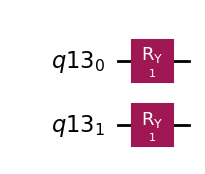

In [31]:
theta = [1, 1]
v_qc = vqc(theta, 2)

## Energy optimization using COBYLA optimizer

1. Define the cost function. Cost function is a function returning the energy for given parameters set.

2. The cost function can use quantum circuit inside. This should be parametrized quantum ciruit. After we circuit is defined we need to tun it and get expectationvalue of desired Hamiltonian. This expectation value is the function return.

3. Here I use QC simulator to get the expectation value.



In [47]:
# defining a cost function
def estim(theta, bit_size, hamiltonian):
    v_qc = vqc(theta, bit_size)
    estimator = StatevectorEstimator()
    job = estimator.run([(v_qc, hamiltonian)])
    estimator_expvals = job.result()[0].data.evs
    print 
    print('Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)
    return estimator_expvals    

In [49]:
# Defining the hamiltonian for which we want to find the ground state
from qiskit.quantum_info import SparsePauliOp
interactions = [("ZZ", [0, 1], 1)]
hamiltonian = SparsePauliOp.from_sparse_list(interactions, num_qubits=bit_size)

#a = estim([0, math.pi/2],2, hamiltonian)

print('Energy expectation is ' + str(a))

Energy expectation is 0.0


In [50]:
#Run COBYLA optimizer
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
x0 = [0, 0]
res = minimize(
        estim,
        x0,
        args=(2 , hamiltonian),
        method="cobyla",
    )

Energy: 1.0
Energy: 0.5403023058681398
Energy: 0.29192658172642894
Energy: -0.028980109210747285
Energy: 0.4973513497371404
Energy: -0.27167146598190123
Energy: -0.5729854585548831
Energy: -0.7642061947022549
Energy: -0.9687269576031717
Energy: -0.8929044761847511
Energy: -0.9925930380309244
Energy: -0.9707379804591577
Energy: -0.9975834724745799
Energy: -0.9972404323740652
Energy: -0.9931756919048833
Energy: -0.9981328462872945
Energy: -0.9974844551013285
Energy: -0.9970572208628994
Energy: -0.9995089929738487
Energy: -0.9998346683959896
Energy: -0.9987827417508532
Energy: -0.9998239796570417
Energy: -0.9999513893679552
Energy: -0.9997091306717344
Energy: -0.9999762370948717
Energy: -0.9999127305484565
Energy: -0.9999597529741984
Energy: -0.9999939580167095
Energy: -0.9999924725241424
Energy: -0.9999982614459071
Energy: -0.999993788973492
Energy: -0.9999994131557828
Energy: -0.9999997941393679
Energy: -0.9999987682599502
Energy: -0.9999998971131066
Energy: -0.9999996130172635
Energy: 

In [45]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.9999999942977512
       x: [ 3.142e+00 -4.663e-05]
    nfev: 47
   maxcv: 0.0

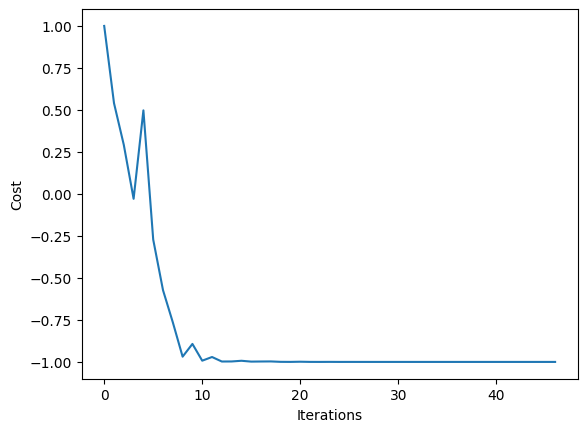

In [56]:
# Plotting Hamiltoniam energy as a function of iteration number
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()